In [11]:
%pip install pydeseq2 pandas numpy matplotlib seaborn gdown

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install pydeseq2 pandas numpy matplotlib seaborn GEOparse

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install rpy2.robjects rpy2.robjects

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.ds import DeseqDataSet
import GEOparse
import rpy2.robjects as robjects
from rpy2.robjects import r
from rpy2.robjects.packages import importr

In [15]:
# Baixar dataset real do GEO (Gene Expression Omnibus)
geo_id = "GSE68849"
gse = GEOparse.get_GEO(geo=geo_id, destdir="./")

09-Apr-2025 19:24:10 DEBUG utils - Directory ./ already exists. Skipping.
09-Apr-2025 19:24:10 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE68nnn/GSE68849/soft/GSE68849_family.soft.gz to ./GSE68849_family.soft.gz
100%|██████████| 21.7M/21.7M [00:02<00:00, 7.90MB/s]  
09-Apr-2025 19:24:14 DEBUG downloader - Size validation passed
09-Apr-2025 19:24:14 DEBUG downloader - Moving /tmp/tmp__awm05z to /workspaces/r_deseq2_docker/GSE68849_family.soft.gz
09-Apr-2025 19:24:14 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE68nnn/GSE68849/soft/GSE68849_family.soft.gz
09-Apr-2025 19:24:14 INFO GEOparse - Parsing ./GSE68849_family.soft.gz: 
09-Apr-2025 19:24:14 DEBUG GEOparse - DATABASE: GeoMiame
09-Apr-2025 19:24:14 DEBUG GEOparse - SERIES: GSE68849
09-Apr-2025 19:24:14 DEBUG GEOparse - PLATFORM: GPL10558
09-Apr-2025 19:24:16 DEBUG GEOparse - SAMPLE: GSM1684095
09-Apr-2025 19:24:16 DEBUG GEOparse - SAMPLE: GSM1684096
09-Apr-2025 19:24:16 

In [20]:
# Obter todas as amostras
samples = list(gse.gsms.keys())
n_samples = len(samples)

# Extrair valores de expressão
count_data = {sample: gse.gsms[sample].table['VALUE'].values for sample in samples}
count_df = pd.DataFrame(count_data, index=gse.gsms[samples[0]].table['ID_REF'])

# Convertendo para inteiros (necessário para DESeq2)
count_df = count_df.astype(int)

# Criar metadados com condição
half_n = n_samples // 2
metadata = pd.DataFrame({'condition': ['control']*half_n + ['treated']*(n_samples - half_n)},
                        index=count_df.columns)

In [21]:
from rpy2.robjects import pandas2ri, globalenv
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

pandas2ri.activate()
DESeq2 = importr("DESeq2")

# Enviar count_df e metadata para o R
globalenv['count_data'] = pandas2ri.py2rpy(count_df)
globalenv['col_data'] = pandas2ri.py2rpy(metadata)

# Criar o dds e rodar DESeq2 no R
ro.r('''
dds <- DESeqDataSetFromMatrix(countData = count_data,
                              colData = col_data,
                              design = ~ condition)

dds <- DESeq(dds)
res <- results(dds)
res_df <- as.data.frame(res)
''')

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In DESeqDataSet(se, design = design, ignoreRank) :
R[write to console]: 
 
R[write to console]:  some variables in design formula are characters, converting to factors



In [22]:
res_py = pandas2ri.rpy2py(globalenv['res_df'])
res_py.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ILMN_1762337,137.773883,-0.029032,0.267882,-0.108377,0.913696,0.979108
ILMN_2055271,128.519002,-0.049788,0.111789,-0.445377,0.656047,0.912043
ILMN_1736007,103.318496,-0.047834,0.106343,-0.449812,0.652846,NaN
ILMN_2383229,102.114738,0.002619,0.105881,0.024737,0.980265,NaN
ILMN_1806310,102.920742,-0.036732,0.105243,-0.349023,0.727072,NaN


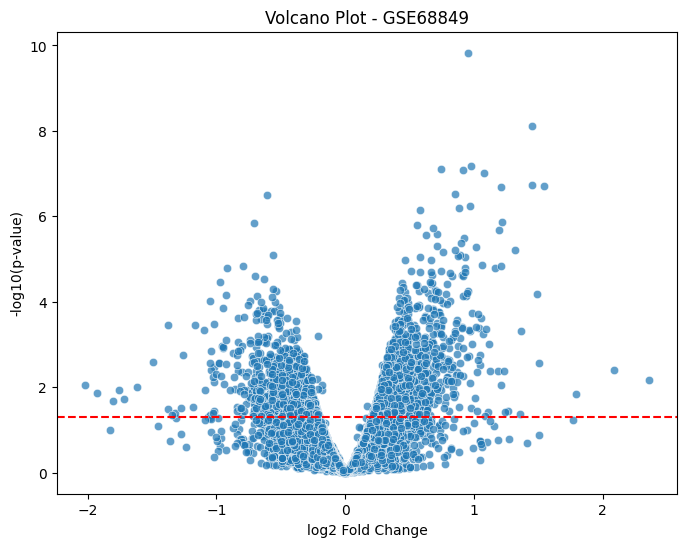

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

res_py = res_py.dropna(subset=['pvalue'])

plt.figure(figsize=(8,6))
sns.scatterplot(data=res_py, x='log2FoldChange', y=-np.log10(res_py['pvalue']), alpha=0.7)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot - GSE68849')
plt.show()